In [1]:
#pip install --upgrade openeo

In [35]:
import geopandas as gpd
import pandas as pd
import os 
import matplotlib.pyplot as plt
import shapely 
from datetime import datetime, timezone


from openeo.processes import and_, is_nan, is_valid, not_, is_nodata, or_, if_
from openeo.local import LocalConnection

from pathlib import Path
import json
import openeo
from shapely.geometry import shape


from utils import extent_from_shp, get_scf_ranges, upsample

import leafmap.foliumap as leafmap
import xarray as xr
from openeo.udf import execute_local_udf
from openeo.rest.auth.config import RefreshTokenStore

from utils_gapfilling import (calculate_cloud_mask, calculate_ndsi, salomonson,
                              binarize, calculate_snow, create_mask)

## Gapfilling
<div>
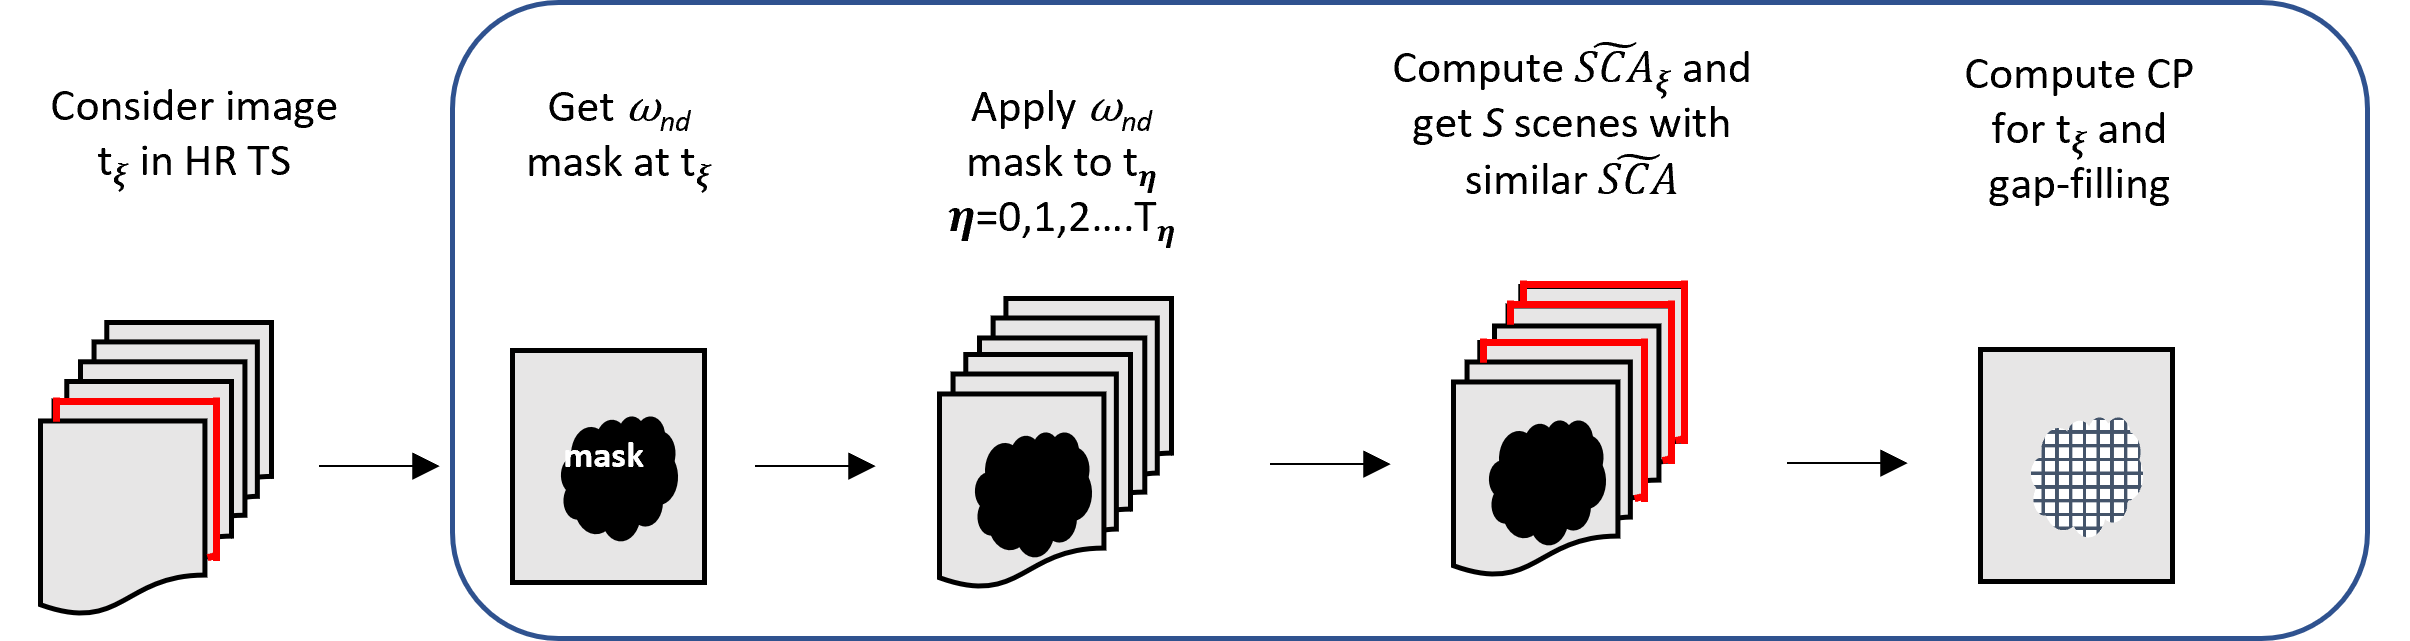
</div>


- Applied to any HR maps with gaps;
- Based on the partial observed/reconstructed SCA, i.e., the SCA computed by excluding the no data values;
- Conditional probability to observe a pixel as snow given the historical HR snow pattern persistence:

 
$$
P_{i}(\omega_{s}|\widetilde{SCA}) = \frac{\sum_{s=0}^{S}x_{i}^{s}}{S}, \: i \subset \text{mask}
$$

Hence it follows:

$$
\begin{split}
    x_{i}=\omega_{s}, \:  & \textbf{if} \:  P_{i}(\omega_{s}|\widetilde{SCA}) = 1 \\
     x_{i}=\omega_{sf}, \:  & \textbf{if} \:  P_{i}(\omega_{s}|\widetilde{SCA}) = 0 
\end{split}
$$


In [36]:
eoconn = openeo.connect('https://openeo.dataspace.copernicus.eu/', auto_validate=False)
eoconn.authenticate_oidc()

eoconn.describe_account()

Authenticated using refresh token.


{'info': {'oidc_userinfo': {'email': 'valentina.premier@eurac.edu',
   'email_verified': True,
   'family_name': 'Premier',
   'given_name': 'Valentina',
   'name': 'Valentina Premier',
   'preferred_username': 'valentina.premier@eurac.edu',
   'sub': '1aa67f75-e178-495e-a131-9f7dffaaae18'}},
 'name': 'Valentina Premier',
 'user_id': '1aa67f75-e178-495e-a131-9f7dffaaae18'}

In [37]:
#RefreshTokenStore().remove()

In [38]:
shp_path = r'/mnt/CEPH_PROJECTS/PROSNOW/research_activity/Senales/auxiliary/boundaries/SenalesCatchment/SenalesCatchment.shp'

catchment_outline = gpd.read_file(shp_path)
bbox = catchment_outline.bounds.iloc[0]

center = (float(catchment_outline.centroid.y), 
          float(catchment_outline.centroid.x))
m = leafmap.Map(center=center, zoom=1)
m.add_vector(shp_path, layer_name="catchment")
m

In [39]:
eps= 0.01 #0.05 # buffer of ca. 500 m
startdate = '2023-08-02'
enddate = '2024-08-15'
cloud_prob = 100

scl = eoconn.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=[startdate, enddate],
    spatial_extent={'west':bbox[0]-eps,
                    'east':bbox[2]+eps,
                    'south':bbox[1]-eps,
                    'north':bbox[3]+eps,
                    'crs':4326},   
    bands=['SCL'],
    max_cloud_cover=cloud_prob,
)

snow = calculate_snow(scl)

In [40]:
# adjust automatically this part
west=631810.
south=5167710.
east=655790.
north=5184190.
area = shapely.geometry.box(west, south, east, north) 
res = 20.

# check that the grid is aligned with a 500 m gri
print('Nr. of low-resolution pixels in the resampled grid (x): {}'.format((east + res/2. - (west - res/2. ))/500.))
print('Nr. of low-resolution pixels in the resampled grid (y): {}'.format((south - res/2. - (north + res/2. ))/-500.))

snow_rsmpl = snow.resample_spatial(resolution=res, 
                                 projection=32632,
                                 method = "nearest")

            
snow_bbox = snow_rsmpl.filter_bbox(west=west, 
                                 south=south, 
                                 east=east, 
                                 north=north, 
                                 crs=32632)
snow_bbox
#snow_bbox.download('snow_bbox.nc')

Nr. of low-resolution pixels in the resampled grid (x): 48.0
Nr. of low-resolution pixels in the resampled grid (y): 33.0


Define constant values to be used in the notebook.

In [41]:
# Ratio betweeen the size of a LR and a HR pixel, e.g., 500 m and 20 m.
pixel_ratio = 25 
# non-valid values
codes = [205, 210, 254, 255] 
nv_value = 205
# Threshold of non valid HR pixels allowed within a LR pixel [%]
nv_thres = 10 

# delta and epsilon: are used to define the SCF ranges. 
# The delta defines the steps, while epsilon represents a security buffer
delta = 10
epsilon = 10

sim_thres = 95
sca_thres = 5.

In [42]:
# cloud/non valid pixels

def mask_clouds(data):
    binary = data.array_element(label = "snow")
    mask = binary > 100  
    return mask

def mask_snow(data):
    binary = data.array_element(label = "snow")
    mask = binary == 100  
    return mask

def mask_valid(data):
    binary = data.array_element(label = "snow")
    mask = binary <= 100  
    return mask

mask_clouds = snow_bbox.apply(mask_clouds)
mask_snow = snow_bbox.apply(mask_snow)
mask_valid = snow_bbox.apply(mask_valid)

#mask_clouds.download('./results/clouds.nc')

Get the time vector

In [43]:
t = snow.dimension_labels('t')
t_array = t.execute() 

Get the AOI as GeoJson: works only in epsg 4326

In [44]:
area = shapely.geometry.box(bbox[0]-eps,bbox[1]-eps,bbox[2]+eps,bbox[3]+eps) 
gdf = gpd.GeoDataFrame({'geometry': area}, index=[0], crs='4326')
gdf = gdf.to_crs('4326')
area_new = eval(gdf.to_json())
area_new
# small differences maybe due to the reprojection?

{'type': 'FeatureCollection',
 'features': [{'id': '0',
   'type': 'Feature',
   'properties': {},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[11.049333075160908, 46.63728095018667],
      [11.049333075160908, 46.806378747905725],
      [10.718538947730554, 46.806378747905725],
      [10.718538947730554, 46.63728095018667],
      [11.049333075160908, 46.63728095018667]]]}}]}

Loop over time
For each date of the Sentinel-2 time-series, select the corresponding cloud mask and apply it to all the other dates of the time-series. 

In [46]:
#t_array = ['2018-02-26']
for date in t_array:
    print('Current date is: ' + date)
    
    # change format -> pandas datetime
    date_dt = pd.to_datetime(str(date),format= "%a, %d %b %Y %H:%M:%S %Z")
    #date_dt = pd.to_datetime(str(date),format= "%Y-%m-%d")
    date_dt = date_dt.replace(tzinfo=timezone.utc).astimezone(tz=None)
    
    # filter the cloud mask to the current time step 
    current_cloud = mask_clouds.filter_temporal([date_dt, date_dt + pd.Timedelta(1, "d")]).drop_dimension('t')
    
    # filter the time-series to the current time step 
    current_snow_map = snow_bbox.filter_temporal([date_dt, date_dt + pd.Timedelta(1, "d")]).drop_dimension('t')
    
    # apply the mask to the time-series
    cube_masked = snow_bbox.mask(current_cloud,replacement=255)
    
    # get the number of total valid pixels (in the non masked area)
    total = cube_masked <= 205
    sum_total = total.aggregate_spatial(geometries=area_new, reducer='sum')
    sum_total_cube = sum_total.vector_to_raster(snow_bbox)
    sum_total_cube = sum_total_cube.rename_labels('bands', ['sum_tot'])
    
    # compute the percentage of similar pixels (same label)
    diff = cube_masked.subtract(current_snow_map)
    
    # similar pixels that are valid (both snow and snow free)
    similar = (diff == 0)*1.0
  
    sum_similar = similar.aggregate_spatial(geometries=area_new, reducer='sum')
    sum_similar_cube = sum_similar.vector_to_raster(snow_bbox)
    sum_similar_cube = sum_similar_cube.rename_labels('bands', ['sum_similar'])
    
    sum_merged = sum_total_cube.merge_cubes(sum_similar_cube)

    similar_perc = sum_merged.band("sum_similar").divide(sum_merged.band("sum_tot")).multiply(100)
    
    # mask dates with similar values 
    mask_sim = (similar_perc > sim_thres)*1.0
    
    # consider the area in the current cloud
    snow = (mask_sim).merge_cubes(current_cloud, overlap_resolver="and").merge_cubes(mask_snow, overlap_resolver="and")
    total = (mask_sim).merge_cubes(current_cloud, overlap_resolver="and").merge_cubes(mask_valid, overlap_resolver="and")
    
    snow = snow.add_dimension(type="bands",name="bands",label="snow")
    total = total.add_dimension(type="bands",name="bands",label="total")

        
    cp_merged = snow.merge_cubes(total)
    sum_cp = cp_merged.reduce_dimension(reducer="sum", dimension="t")
    # how many times a pixels is snow over time
    #sum_cp_snow = snow.reduce_dimension(reducer="sum", dimension="t")
    # how many times a pixels is valid over time (occurences)
    #sum_cp_tot = total.reduce_dimension(reducer="sum", dimension="t")


    # compute the conditional probabilities
    cp = sum_cp.band("snow").divide(sum_cp.band("total"))
    
    snow_gapfilled = current_snow_map.mask(cp==1, replacement=100)
    snow_gapfilled = snow_gapfilled.mask(cp==0, replacement=0)
    
    # append in a list and later merge into a datacube (merge_cubes), e.g. 5 dates-> separate job
    break

#current_snow_map.download('./results/current_snow_map.nc')
#snow_gapfilled.download('./results/snow_gapfilled.nc')

Current date is: Fri, 04 Aug 2023 00:00:00 GMT


ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [47]:
job_options = {
        "executor-memory": "3G",
        "executor-memoryOverhead": "4G",
        "executor-cores": "2"
}

In [48]:
snow_gapfilled.execute_batch(title="Gap-filled image",
                             outputfile="./results/snow_gapfilled.nc", job_options=job_options)


0:00:00 Job 'j-240902e3d1524ff192f027e8974b7b1e': send 'start'
0:00:26 Job 'j-240902e3d1524ff192f027e8974b7b1e': created (progress 0%)
0:00:31 Job 'j-240902e3d1524ff192f027e8974b7b1e': created (progress 0%)
0:00:37 Job 'j-240902e3d1524ff192f027e8974b7b1e': created (progress 0%)
0:00:45 Job 'j-240902e3d1524ff192f027e8974b7b1e': created (progress 0%)
0:00:55 Job 'j-240902e3d1524ff192f027e8974b7b1e': running (progress N/A)
0:01:08 Job 'j-240902e3d1524ff192f027e8974b7b1e': running (progress N/A)
0:01:23 Job 'j-240902e3d1524ff192f027e8974b7b1e': running (progress N/A)
0:01:42 Job 'j-240902e3d1524ff192f027e8974b7b1e': running (progress N/A)
0:02:06 Job 'j-240902e3d1524ff192f027e8974b7b1e': running (progress N/A)
0:02:36 Job 'j-240902e3d1524ff192f027e8974b7b1e': running (progress N/A)
0:03:19 Job 'j-240902e3d1524ff192f027e8974b7b1e': running (progress N/A)
0:04:10 Job 'j-240902e3d1524ff192f027e8974b7b1e': running (progress N/A)
0:05:14 Job 'j-240902e3d1524ff192f027e8974b7b1e': running (progre

<BatchJob job_id='j-240902e3d1524ff192f027e8974b7b1e'>

In [43]:
cp_job = cp.create_job(title="CP", out_format="GTiff")
cp_job.start_and_wait()


0:00:00 Job 'j-24072341879748e09e4955920946a571': send 'start'
0:05:18 Job 'j-24072341879748e09e4955920946a571': created (progress 0%)
0:05:24 Job 'j-24072341879748e09e4955920946a571': created (progress 0%)
0:05:32 Job 'j-24072341879748e09e4955920946a571': created (progress 0%)
0:05:47 Job 'j-24072341879748e09e4955920946a571': created (progress 0%)
0:05:57 Job 'j-24072341879748e09e4955920946a571': error (progress N/A)
Your batch job 'j-24072341879748e09e4955920946a571' failed. Error logs:
[{'id': '[1721739051920, 166906]', 'time': '2024-07-23T12:50:51.920Z', 'level': 'error', 'message': 'Error initializing SparkContext.'}, {'id': '[1721739051976, 555953]', 'time': '2024-07-23T12:50:51.976Z', 'level': 'error', 'message': 'OpenEO batch job failed: Exception during Spark execution: java.net.SocketTimeoutException: connect timed out'}, {'id': '[1721739052097, 385357]', 'time': '2024-07-23T12:50:52.097Z', 'level': 'error', 'message': 'Batch job error stack trace with locals'}]
Full logs can

JobFailedException: Batch job 'j-24072341879748e09e4955920946a571' didn't finish successfully. Status: error (after 0:05:58).